# 第8章: ニューラルネット
自然言語処理100本ノック (https://nlp100.github.io/ja/) の第8章です。


第6章で取り組んだニュース記事のカテゴリ分類を題材として，ニューラルネットワークでカテゴリ分類モデルを実装する．なお，この章ではPyTorch, TensorFlow, Chainerなどの機械学習プラットフォームを活用せよ．

## 70. 単語ベクトルの和による特徴量
長いので省略するが、問題50で扱った記事見出し-カテゴリデータについて、
記事の特徴量を各単語ベクトルの平均を取れとのこと

In [1]:
import pandas as pd

df = pd.read_csv("NewsAggregatorDataset/newsCorpora.csv", sep="\t", index_col=0, names=["id", "title", "url", "publisher", "category", "story", "hostname", "timestamp"])
df.head()

,title,url,publisher,category,story,hostname,timestamp
id,,,,,,,
1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027


In [2]:
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin.gz', binary=True)

In [3]:
import numpy as np

def create_seq_feature(text):
    word_list = text.split(" ")
    word_list = [w.rstrip(",") for w in word_list]
    word_list = [w.rstrip(",") for w in word_list]
    word_list = [w for w in word_list if w in model.vocab.keys()]
    if len(word_list) == 0:
        word_list = ["%"]
    feature_array = np.array([model[w] for w in word_list])
    seq_feature = feature_array.mean(axis=0)
    return seq_feature

ビジネス (b) を 0、科学技術 (t) を 1、エンターテインメント (e) を 2、健康 (m) を 3 にエンコードする 

In [4]:
def cat_encoder(cat):
    if cat == "b":
        return 0
    elif cat == "t":
        return 1
    elif cat == "e":
        return 2
    elif cat == "m":
        return 3
    else:
        raise NotImplementedError
        
cat_list = ["m", "e", "t", "b"]
print([cat_encoder(c) for c in cat_list])

[3, 2, 1, 0]


In [5]:
def table_to_X_y(df):
    text_list = list(df["title"])
    features = [create_seq_feature(t) for t in text_list]
    X = np.stack(features, axis=0)
    cat_list = list(df["category"])
    y = np.array([cat_encoder(c) for c in cat_list])
    return X, y

6章と同様にしてテーブルを分割

In [6]:
valid_publisher = ["Reuters", "Huffington Post", "Businessweek", "Contactmusic.com", "Daily Mail"]
df = df.loc[df["publisher"].isin(valid_publisher), :]
df = df.sample(frac=1, random_state=42)
df = df.reset_index(drop=True)

total_size = len(df)
train_size = int(0.8*total_size)
valid_size = int(0.1*total_size)
test_size = total_size - train_size - valid_size

train_df = df.iloc[:train_size, :]
valid_df = df.iloc[train_size:train_size+valid_size, :]
test_df = df.iloc[train_size+valid_size:, :]


print(len(train_df))
print(len(valid_df))
print(len(test_df))

10672
1334
1334


In [7]:
import numpy as np

X_train, y_train = table_to_X_y(train_df)
X_val, y_val = table_to_X_y(valid_df)
X_test, y_test = table_to_X_y(test_df)

np.save( "train.npy", np.concatenate([X_train, y_train[:, None]], axis=1))
np.save( "val.npy", np.concatenate([X_val, y_val[:, None]], axis=1))
np.save( "test.npy", np.concatenate([X_test, y_test[:, None]], axis=1))

In [8]:
X_train.shape

(10672, 300)

## 71. 単層ニューラルネットワークによる予測
問題70で保存した行列を読み込み，学習データについて以下の計算を実行せよ．

ここも問題文が長いので省略するが、単層の全結合層＋softmaxの出力を取れと書いてある。

In [9]:
import torch
import torch.nn as nn

class SingleLayerNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(300, 4, bias=False)
        self.active = nn.Softmax()
    
    def forward(self, x):
        return self.active(self.linear(x))

In [10]:
slnn = SingleLayerNN()

x = torch.from_numpy(X_train[0:4, :].astype(np.float32)).clone()

y = slnn(x)

print(y)

tensor([[0.2475, 0.2523, 0.2559, 0.2443],
        [0.2322, 0.2691, 0.2484, 0.2504],
        [0.2298, 0.2634, 0.2650, 0.2418],
        [0.2563, 0.2512, 0.2430, 0.2495]], grad_fn=<SoftmaxBackward>)


C:\Anaconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


## 72. 損失と勾配の計算
学習データの事例x1
と事例集合x1,x2,x3,x4
に対して，クロスエントロピー損失と，行列W
に対する勾配を計算せよ．なお，ある事例xi
に対して損失は次式で計算される．

li=−log[事例xiがyiに分類される確率]
ただし，事例集合に対するクロスエントロピー損失は，その集合に含まれる各事例の損失の平均とする．

In [20]:
cel = nn.CrossEntropyLoss()

x = torch.from_numpy(X_train[0:4, :].astype(np.float32)).clone()
y_pred = slnn(x)

loss = cel(y_pred, torch.LongTensor(y_train[0:4]))
loss.backward()

print(slnn.linear.weight.grad)

C:\Anaconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


tensor([[ 0.0002, -0.0071,  0.0006,  ...,  0.0063, -0.0078,  0.0109],
        [ 0.0004,  0.0026, -0.0024,  ..., -0.0040,  0.0032, -0.0058],
        [-0.0009,  0.0021,  0.0042,  ...,  0.0014,  0.0015,  0.0004],
        [ 0.0003,  0.0024, -0.0023,  ..., -0.0037,  0.0030, -0.0055]])


## 73. 確率的勾配降下法による学習
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，行列W
を学習せよ．なお，学習は適当な基準で終了させればよい（例えば「100エポックで終了」など）

In [24]:
from torch.optim import SGD

slnn = SingleLayerNN()
cel = nn.CrossEntropyLoss()
optimizer = SGD(slnn.parameters(), lr=0.001)

for i in range(100):
    x = torch.from_numpy(X_train.astype(np.float32)).clone()
    y_pred = slnn(x)
    loss = cel(y_pred, torch.LongTensor(y_train))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

C:\Anaconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


## 74. 正解率の計測
問題73で求めた行列を用いて学習データおよび評価データの事例を分類したとき，その正解率をそれぞれ求めよ

In [25]:
with torch.no_grad():
    x_train = torch.from_numpy(X_train.astype(np.float32)).clone()
    y_train_pred = slnn(x_train).numpy().argmax(axis=1)
    x_test = torch.from_numpy(X_test.astype(np.float32)).clone()
    y_test_pred = slnn(x_test).numpy().argmax(axis=1)
acc_train = np.equal(y_train_pred, y_train).mean()
acc_test = np.equal(y_test_pred, y_test).mean()
    
print(f"学習データでの正解率は{acc_train}")
print(f"評価データでの正解率は{acc_test}")

学習データでの正解率は0.25384182908545727
評価データでの正解率は0.25262368815592207


C:\Anaconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


## 75. 損失と正解率のプロット
問題73のコードを改変し，各エポックのパラメータ更新が完了するたびに，訓練データでの損失，正解率，検証データでの損失，正解率をグラフにプロットし，学習の進捗状況を確認できるようにせよ．

C:\Anaconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


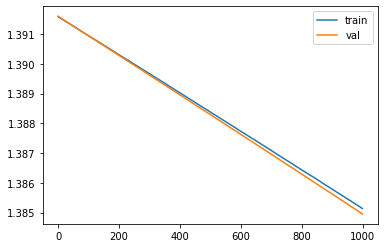

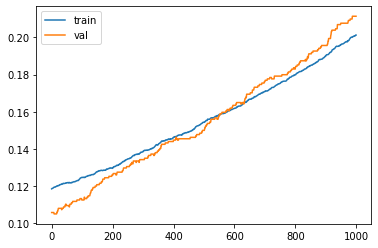

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

slnn = SingleLayerNN()
cel = nn.CrossEntropyLoss()
optimizer = SGD(slnn.parameters(), lr=0.001)

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for i in range(1000):
    x = torch.from_numpy(X_train.astype(np.float32)).clone()
    y_pred = slnn(x)
    loss = cel(y_pred, torch.LongTensor(y_train))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        x_train = torch.from_numpy(X_train.astype(np.float32)).clone()
        y_train_pred = slnn(x_train)
        train_loss = cel(y_train_pred, torch.LongTensor(y_train)).item()
        x_val = torch.from_numpy(X_val.astype(np.float32)).clone()
        y_val_pred = slnn(x_val)
        val_loss = cel(y_val_pred, torch.LongTensor(y_val)).item()
    acc_train = np.equal(y_train_pred.numpy().argmax(axis=1), y_train).mean()
    acc_val = np.equal(y_val_pred.numpy().argmax(axis=1), y_val).mean()
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    train_acc_list.append(acc_train)
    val_acc_list.append(acc_val)
    
plt.plot(train_loss_list, label="train")
plt.plot(val_loss_list, label="val")
plt.legend()
plt.show()

plt.plot(train_acc_list, label="train")
plt.plot(val_acc_list, label="val")
plt.legend()
plt.show()


## 76. チェックポイント
問題75のコードを改変し，各エポックのパラメータ更新が完了するたびに，チェックポイント（学習途中のパラメータ（重み行列など）の値や最適化アルゴリズムの内部状態）をファイルに書き出せ．

C:\Anaconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


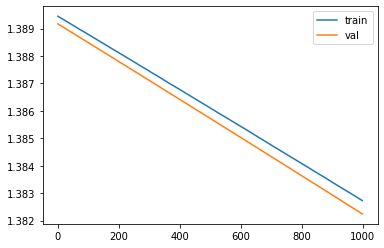

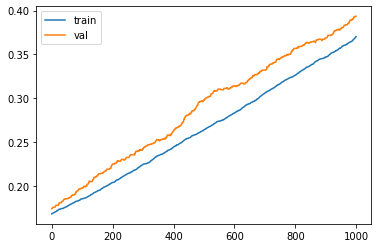

In [28]:
import os

slnn = SingleLayerNN()
cel = nn.CrossEntropyLoss()
optimizer = SGD(slnn.parameters(), lr=0.001)

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

output_dir = "Q76"
os.makedirs(output_dir, exist_ok=True)

for i in range(1000):
    x = torch.from_numpy(X_train.astype(np.float32)).clone()
    y_pred = slnn(x)
    loss = cel(y_pred, torch.LongTensor(y_train))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    torch.save(slnn.state_dict(), os.path.join(output_dir, f"{i}.pth"))
    
    with torch.no_grad():
        x_train = torch.from_numpy(X_train.astype(np.float32)).clone()
        y_train_pred = slnn(x_train)
        train_loss = cel(y_train_pred, torch.LongTensor(y_train)).item()
        x_val = torch.from_numpy(X_val.astype(np.float32)).clone()
        y_val_pred = slnn(x_val)
        val_loss = cel(y_val_pred, torch.LongTensor(y_val)).item()
    acc_train = np.equal(y_train_pred.numpy().argmax(axis=1), y_train).mean()
    acc_val = np.equal(y_val_pred.numpy().argmax(axis=1), y_val).mean()
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    train_acc_list.append(acc_train)
    val_acc_list.append(acc_val)
    
plt.plot(train_loss_list, label="train")
plt.plot(val_loss_list, label="val")
plt.legend()
plt.show()

plt.plot(train_acc_list, label="train")
plt.plot(val_acc_list, label="val")
plt.legend()
plt.show()

## 77. ミニバッチ化
問題76のコードを改変し，B
事例ごとに損失・勾配を計算し，行列W
の値を更新せよ（ミニバッチ化）．B
の値を1,2,4,8,…
と変化させながら，1エポックの学習に要する時間を比較せよ．

In [ ]:
slnn = SingleLayerNN()
cel = nn.CrossEntropyLoss()
optimizer = SGD(slnn.parameters(), lr=0.001)

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

output_dir = "Q77"
os.makedirs(output_dir, exist_ok=True)

BATCH_SIZE_LIST = [1, 2, 4, 8, 16]

for i in range(1000):
    for batch_size in BATCH_SIZE_LIST:
        X = X_train.copy()
        
    x = torch.from_numpy(X_train.astype(np.float32)).clone()
    y_pred = slnn(x)
    loss = cel(y_pred, torch.LongTensor(y_train))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    torch.save(slnn.state_dict(), os.path.join(output_dir, f"{i}.pth"))
    
    with torch.no_grad():
        x_train = torch.from_numpy(X_train.astype(np.float32)).clone()
        y_train_pred = slnn(x_train)
        train_loss = cel(y_train_pred, torch.LongTensor(y_train)).item()
        x_val = torch.from_numpy(X_val.astype(np.float32)).clone()
        y_val_pred = slnn(x_val)
        val_loss = cel(y_val_pred, torch.LongTensor(y_val)).item()
    acc_train = np.equal(y_train_pred.numpy().argmax(axis=1), y_train).mean()
    acc_val = np.equal(y_val_pred.numpy().argmax(axis=1), y_val).mean()
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    train_acc_list.append(acc_train)
    val_acc_list.append(acc_val)
    
plt.plot(train_loss_list, label="train")
plt.plot(val_loss_list, label="val")
plt.legend()
plt.show()

plt.plot(train_acc_list, label="train")
plt.plot(val_acc_list, label="val")
plt.legend()
plt.show()